In [75]:
import sys
print(sys.executable)
!pip install micrograd graphviz
!pip install numpy matplotlib
!pip install torch

/usr/bin/python3
     |████████████████████████████████| 887.4 MB 6.5 MB/s eta 0:00:015    |█▉                              | 50.6 MB 3.2 MB/s eta 0:04:24     |█████████████▎                  | 368.0 MB 9.6 MB/s eta 0:00:55     |█████████████████▊              | 490.2 MB 8.7 MB/s eta 0:00:46     |██████████████████████▍         | 622.4 MB 4.7 MB/s eta 0:00:57
     |████████████████████████████████| 317.1 MB 5.9 MB/s eta 0:00:016    |████▍                           | 43.5 MB 10.8 MB/s eta 0:00:26     |██████████████████████▋         | 224.5 MB 4.9 MB/s eta 0:00:19
     |████████████████████████████████| 557.1 MB 74 kB/s  eta 0:00:015████                 | 261.1 MB 5.6 MB/s eta 0:00:53     |██████████████████████████      | 450.9 MB 10.5 MB/s eta 0:00:11
     |████████████████████████████████| 21.0 MB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 849 kB 5.9 MB/s eta 0:00:01


In [2]:
from micrograd.engine import Value

a = Value(-4.0)
b = Value(2.0)
c = 2*a+b

print(c.data)
c.backward() #  -> recursive differentiation. tree를 타고 올라 가면서 backpropagation을 한다.
# dc/da 와 dc/db 를 계산하게 되는데 이건 명확하다.
print(f"grad a:{a.grad}")
print(f"grad b:{b.grad}")
# 

-6.0
grad a:2
grad b:1


In [3]:
"""
a의 gradient가 말하는것은 a를 바꾸면 기울기 2로 변경이되고,
b의 gradient가 말하는것은 b를 조정하면 기울기 1 간격으로 변경이된다는것.
c가 어떻게 변화할지를 알려준다.
실제 back propagation 은 되게 간단하게 구성되어 있다.
        
"""

'\na의 gradient가 말하는것은 a를 바꾸면 기울기 2로 변경이되고,\nb의 gradient가 말하는것은 b를 조정하면 기울기 1 간격으로 변경이된다는것.\nc가 어떻게 변화할지를 알려준다.\n실제 back propagation 은 되게 간단하게 구성되어 있다.\n        \n'

In [87]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [5]:
def f(x):
    return 3*x**2 - 4*x + 5

xs = np.arange(-5,5,0.25)
print(xs)

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]


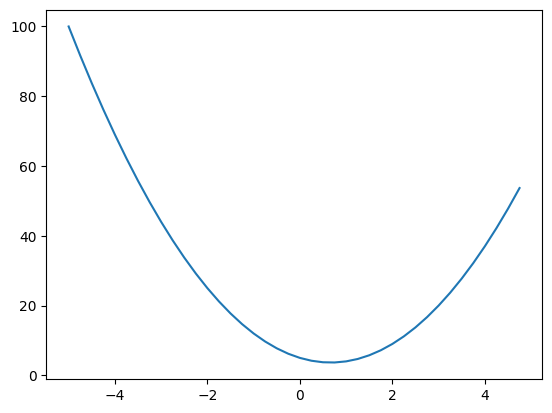

In [6]:
ys = f(xs) 
ys # f(x)를 모든 x에 대해 실행
plt.plot(xs,ys)

In [7]:
# derivative를 생각해보면, f'(x) 에서 진행했겠지? 
# 하지만 아무도 neural network에서는 derivative를 식으로 나타내려고 하지 않아. 엄청 복잡하잖아.
# derivative 라는건, 변화량이야. slope(increasing, decreasing), how much 를 나타낸다.

h = 0.001
x = 3.0
(f(x+h)-f(x))/h # 3.0 -> 3.001 로갈때 증가하기를 바란다. 고로 양수이겠지. 여기서 h를 점점 줄여나가면 derivative는 엄청 줄어들겠지

14.00300000000243

In [8]:
"""
그럼 x= -3 일떄는 어떨까? 
감소하기를 바라니까 음수가 나와야한다. 
그럼 2/3 일때는? 변화량이 0에 가깝다. 거의 변하지 않기때문에.
"""

"""
이번에 input이 3개면 어떻게 될까?
d의 변화량은 어떻게 확인하지?
"""

a = 2.0
b = -3.0
c = 10.0
d = a*b + c 
print(d)

4.0


In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c 

a+=h
d2 = a*b +c 

print("d1, d2", d1, d2)
print("slope", (d2-d1)/h) # a가 조금증가했을때 얼마나 변화했을까? == slope
# b를 조금 증가시켰을때
# c를 조금 증가시켰을때 

d1, d2 4.0 3.999699999999999
slope -3.000000000010772


In [53]:
# 이런걸 담아놓으려면

class Value:
    def __init__(self, data, _children=(),_op='',label =''):
        self.data = data
        self.grad = 0.0 # does not impact the output at first. 
        self._prev= set(_children)
        self._backward = lambda: None #어떻게 output gradient를 input gradient에 어떻게 반영할지. 즉 dx1w1/dx1 이런걸 x1w1.grad 에 곱해줘야지 x1의 grad를 알 수 있는거잖아. dx1w1/dx1 이 값을 저장할 곳이 필요하다 
        # 마지막 node는 아무것도 곱할게없으니 그냥두는거. 
        self._op = _op
        self.label=label
    def __repr__(self):  # 없으면 print하면 <__main__.Value at 0x1313212> 이런게 나온다
        return f"Value(data={self.data})"
    def __add__(self, other): #a.__add__(b) == a+b 이런식으로 된다.
        out = Value(self.data + other.data, (self,other),'+')
        def _backward():
            """self.grad 와 other.grad 를 배정해주는 함수를 만들어주고 싶다. 그래서 +노드에서 자식 노드들의 gradient를 계산해줄 수 있게.
            그러려면, (self.data + other.data) 의 grad를 뽑아서 더하기에 대한 미분값을 곱해줘야 한다. 
            w1x1의 grad는 (w1x1 + w2x2).grad * d(w1x1 +w2x2)/d(w1x1) 이기 때문에  (w1x1 + w2x2).grad * 1 이되고,
            w2x2의 grad는 (w1x1 + w2x2).grad * d(w1x1 +w2x2)/d(w2x2) 이기 때문에  (w1x1 + w2x2).grad * 1 이된다.
            고로 backward 함수가 불리면 out.grad *1 을 각 self 와 other의 grad에 배정해주면 된다.
            """
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward #함수를 배정한다.
        return out
    def __mul__(self, other):
        out = Value(self.data * other.data, (self,other),'*') # "label" 을 *로 붙여놨지만 사실 w1x1 노드처럼 곱셈의 결과물이 들어있는 노드
        
        def _backward():
            """
            +의 grad처럼 , 미분하면 결국 상대방이 나온다. d(w1*x1)/d(w1) = x1 
            """
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad 
        
        out._backward = _backward
        return out
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) -1)/(math.exp(2*n)+1) # tanh 정의
        out = Value(t, (self,),'tanh')
        def _backward():
            """
            tanh의 미분은 1-(tanh(x))**2 이다. 우린 tanh(x)을 알고있어. t야. 
            """
            self.grad += (1 - t**2) * out.grad   
        out._backward = _backward
        return out
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo): #우리는 o 노드부터 방문해야해서 reversed
            node._backward()
            
            
a= Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e= a*b; e.label='e'
# a+b # 당연히 선언 안 해놨으니 error
# a*b
# d = a*b + c
# d
d= e+c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [5]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

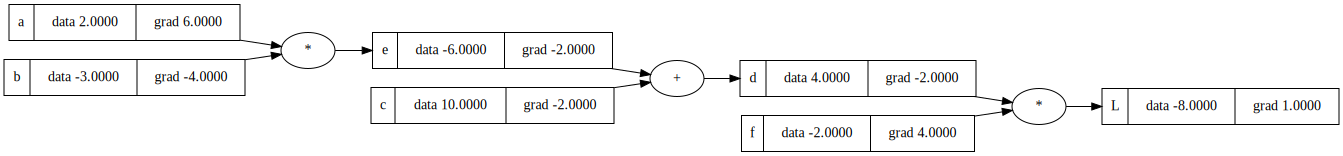

In [45]:
"""
우리는 최종 결과물 L에 대해 각각의 derivative를 확인한다.
da/dL
db/dL
...

Loss function에 각 neuron들이 어떻게 영향을 미치는지 궁금하다.
우리들의 output으로 볼 수 있는 Loss function이 leaf nodes들에 의해 영향을 받는다.
그런데 실제 데이터는 고정인데 weight가 바뀌어야 한다. 그래서 우리는 grad라는 weight 변수를 만든다.
grad는 derivative of L respective to 아래의 value들.

"""
L.grad = 1.0
d.grad=f.data
f.grad=d.data

c.grad= -2.0 # d.data
e.grad = -2.0 # d.data 

a.grad= (-2.0 * -3.0)
b.grad = (-2.0 * 2.0) # e= a*b 
draw_dot(L)

In [ ]:
"""
L의 grad부터 구해보자.
L을 h만큼 바꿨을떄 L이 얼마나 바뀔까? h만큼 바뀔테니 grad==1 
dL / dd 하면 뭘까? L = d*f 니까 f라는걸 알지? 이게 d의 grad
f의 grad도 d야. 

dL/ dc 도 알아야한다. dL/dd를 아니까 d가 어떻게 L에 영향을 미쳤는지 안다. dL/ dc는 d를 통해 영향을 미쳤다. 
dd/ dc ? 는 무엇인가?
d = c+e니까, dd/dc = 1 
dd/de 또한 1 .

local derivative들이 다 1인셈. 
chain rule, 
WANT:
dL/dc = dL/dd * dd/dc 


KNOW:
dL/dd 
dd/dc ==1 -> +의 gradient는 그냥 routed. 그대로 전달된다. 모든 children에게 그대로 gradient를 나눠준다.
dd/de ==1 -> ''

WANT: 
dL/da == (dL / de) * ( de / da ==local gradient) # e= a*b   
dL/db 

KNOW:

dL/de

"""
def lol():
    a= Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e= a*b; e.label='e'
    d= e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

        
    h=0.0001
    a= Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e= a*b; e.label='e'
    d= e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data + h

    print((L2-L1)/h)
    
lol()


0.9999999999976694


In [21]:
"""
이제 nudge out to make L grows. 
grad 가 양수라면, a를 예로들면

dL/da 가 양수인셈이다. 그러면 L을 키우려면 a값을 키우면 된다 (기울기가 > 0)
이 경우 기존 a + (dL/da * learning rate) 를 하면 결과값인 L이 커진다.

반면 grad가 음수라면

dL/da 가 음수인 셈이다. 그러면 L을 키우려면 a값을 줄여나가야 한다. (기울기가 < 0)

a + (dL/da * learning rate) 하면 a값이 작아져서 결과값인 L이 작아진다.

결국 두 식이 똑같다.
"""

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e= a*b
d= e+c
L= d*f

print(L.data)

-7.286496


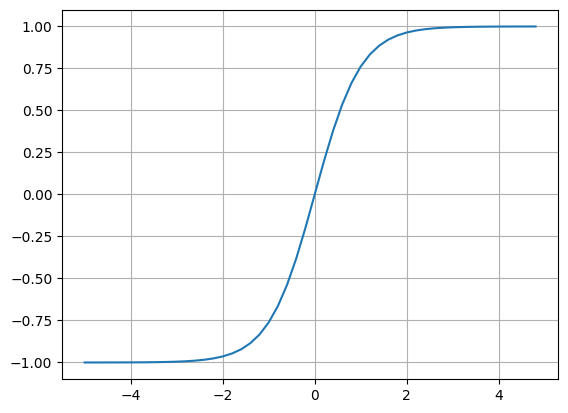

In [7]:
 """
 이제 뉴런을 만들꺼다.
 x0: 어떤 input
 w0: 어떤 weight
 
 x0 * w0 + x1 * w1 ... + b <- input값에 상관없이 이 뉴런의 중요도를 추가해주는? 
 
 이걸 이제 activation function에 넣어. sigmoid 같은게 있는데, tanh() 같은걸 적용할수도 있다.
 tanh는 아래처럼 생겼고. -1~1 사이값을 준다.
 """
plt.plot(np.arange(-5,5,0.2) , np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [46]:
# 두개 input이 들어오는 neuron을 생각해보자
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label='n'
#이제 우리는 n에 대해서 activation function을 지정하고싶어. 그래서 output을 
o = n.tanh() ;o.label='o'
# draw_dot(n)  


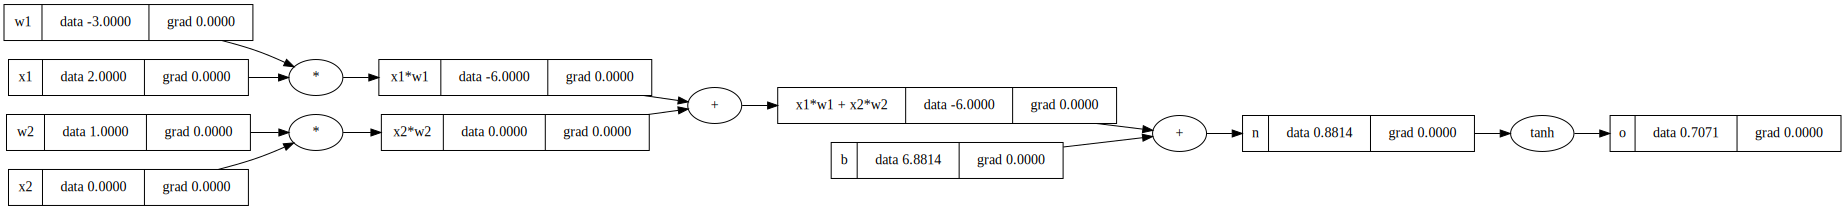

In [47]:
draw_dot(o)

In [22]:
o.grad = 1.0 # 일테고
# backprop 하려고 하는데 tanh의 derivative는 뭘까? 1-(tanh(x))^2 라네. do/dn = 1 - tanh(n)**2 근데 tanh는 이미 o이지. (0말고 O) 
# 왜냐하면 tanh(n)이 O값이 된거니까 지금.  1-o**2 
n.grad = 1-o.data**2

# " 더앞에는, +로 x1w1x2w2 + b가 있다. 각각의 grad는 

In [23]:
x1w1x2w2.grad = 0.5
b.grad =0.5
# +는 미분이 1로 나와서 앞의 grad인 n.grad를 그대로 받아오게 된다.

x1w1.grad =0.5
x2w2.grad = 0.5

# 얘네도 +

# 이제 x1*w1 을 보면서 x1 , w1 각각에 grad가 어떻게 올지 봐야한다.
# 지금은 각자 w1, x1 이 dx1w1/dx1 dx1w1/dw1 인거야.
# 각각의 미분값을 전의 grad에 곱해준다

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad #이러면 지금 x2=0 이라서, w2.grad는 0이 된다. 그런데
# 이게 무슨의미인지 파악해보면, 우리가 미분을 하는 이유는 final output에 어떻게 영향을 미치는지 알아보기 위해서이다.
# w2를 바꾸면 output이 어떻게 바뀔까? 암만 바꿔도 x2*w2는 그대로일거야 현재 x2가 0인 한은. 그렇기 때문에 w2.grad는 0이 될수밖에없다.


x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

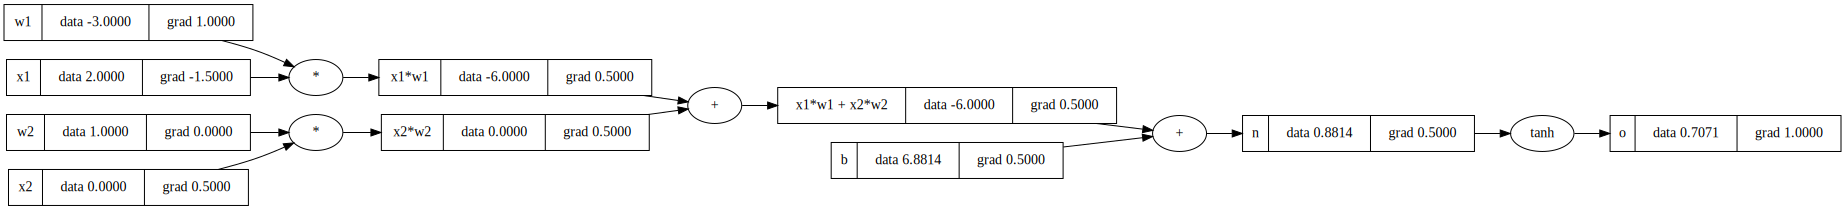

In [51]:
draw_dot(o)

In [49]:
# o.grad = 1.0 # 우리가 grad를 다 곱하기 연산으로 하기때문에 처음시작할때 최종 grad는 1.0으로 세팅해줘야하는 문제가 존재
o._backward()

In [37]:
n._backward()

In [39]:
b._backward() #leafnode는 None 하지
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

In [42]:
"""
topological sort 가 필요하다.
이건 그래프이긴 한데 모든 node가 한쪽방향으로만 흐르는 그런 그래프이다.
backward() 함수를 연속적으로 부르고싶긴 하지만, 같은 노드에 대해서 또 부르고 싶지 않잖아.
그래서 topological order로 노드들의 _backward()를 불러.
"""
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo): #우리는 o 노드부터 방문해야해서 reversed
    node._backward()

In [50]:
o.backward()

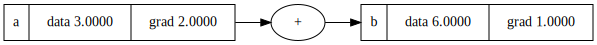

In [54]:
# 근데 우리에게 아직 버그가 남았다.
"""
"""
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward() # 이러면 gradient가 안맞다. 왜냐하면, 2a 로 계산되야하니까 gradient는 2여야 하는것이다. 근데 지금은 그냥 assign 되고 있어 accumulate 해야해. multivariable chain rule 의 경우를 확인해야한다.
draw_dot(b)

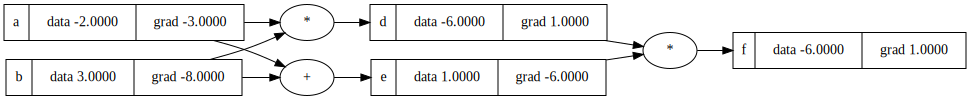

In [55]:
a= Value(-2.0, label='a')
b = Value(3.0, label='b')
d= a*b ; d.label='d'
e = a+b ; e.label='e'
f= d*e; f.label='f'

f.backward()

draw_dot(f)


In [ ]:
"""
자 이제, Value 클래스의 능력을 늘리기. 
"""
a = Value(2.0) #a +1 은 아직 안돼. 왜냐하면 Value를 받거든


In [93]:
# 이런걸 담아놓으려면

class Value:
    def __init__(self, data, _children=(),_op='',label =''):
        self.data = data
        self.grad = 0.0 # does not impact the output at first. 
        self._prev= set(_children)
        self._backward = lambda: None #어떻게 output gradient를 input gradient에 어떻게 반영할지. 즉 dx1w1/dx1 이런걸 x1w1.grad 에 곱해줘야지 x1의 grad를 알 수 있는거잖아. dx1w1/dx1 이 값을 저장할 곳이 필요하다 
        # 마지막 node는 아무것도 곱할게없으니 그냥두는거. 
        self._op = _op
        self.label=label
    def __repr__(self):  # 없으면 print하면 <__main__.Value at 0x1313212> 이런게 나온다
        return f"Value(data={self.data})"
    def __neg__(self): # -self
        return self * -1 
    
    def __add__(self, other): #a.__add__(b) == a+b 이런식으로 된다.
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other),'+')
        def _backward():
            """self.grad 와 other.grad 를 배정해주는 함수를 만들어주고 싶다. 그래서 +노드에서 자식 노드들의 gradient를 계산해줄 수 있게.
            그러려면, (self.data + other.data) 의 grad를 뽑아서 더하기에 대한 미분값을 곱해줘야 한다. 
            w1x1의 grad는 (w1x1 + w2x2).grad * d(w1x1 +w2x2)/d(w1x1) 이기 때문에  (w1x1 + w2x2).grad * 1 이되고,
            w2x2의 grad는 (w1x1 + w2x2).grad * d(w1x1 +w2x2)/d(w2x2) 이기 때문에  (w1x1 + w2x2).grad * 1 이된다.
            고로 backward 함수가 불리면 out.grad *1 을 각 self 와 other의 grad에 배정해주면 된다.
            """
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward #함수를 배정한다.
        return out
    def __sub__(self,other):
        return self + (-other)
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*') # "label" 을 *로 붙여놨지만 사실 w1x1 노드처럼 곱셈의 결과물이 들어있는 노드
        
        def _backward():
            """
            +의 grad처럼 , 미분하면 결국 상대방이 나온다. d(w1*x1)/d(w1) = x1 
            """
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad 
        out._backward = _backward
        return out
    def __pow__(self, other): #other이 int나 float이어야한다. 아니면 pow derivative가 달라지지. 식이 더많아지니까. (내부 미분필요)
        assert isinstance(other, (int, float)), "only support int/float powers for now"  
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward(): #out 은 (self ^ other). derivative는 (other * (self ^(other-1))
            # self.grad += out.grad * (other * out/self.data )
            self.grad += other * (self.data **(other-1)) * out.grad
        out._backward = _backward
        return out
    def __radd__(self, other):
        return self + other
    def __rmul__(self, other): #이걸 정의 안 하면 a * 2는 되는데 2 * a가 안되는 문제점.
        return self * other 
    
    def __truediv__(self, other):
        return self * other**-1
    

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) -1)/(math.exp(2*n)+1) # tanh 정의
        out = Value(t, (self,),'tanh')
        def _backward():
            """
            tanh의 미분은 1-(tanh(x))**2 이다. 우린 tanh(x)을 알고있어. t야. 
            """
            self.grad += (1 - t**2) * out.grad   
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward(): # derivative 뭔지 알지?
            self.grad += out.grad * out.data
        out._backward = _backward
        
        return out    
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo): #우리는 o 노드부터 방문해야해서 reversed
            node._backward()

            
a= Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e= a*b; e.label='e'
# a+b # 당연히 선언 안 해놨으니 error
# a*b
# d = a*b + c
# d
d= e+c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

L._prev

{Value(data=-2.0), Value(data=4.0)}

In [68]:
a=Value(2.0)
a.exp()
b = Value(4.0) # a/b 를 하고싶으면? a * (1/b) == a * (b**-1) 이랑 같은거야. 그러니까 division을 만들지말고, x^k 연산에 대해서 구현하자.
a/b
# a-b를 하고싶으면? a+ (-1*other)
a-b

Value(data=-2.0)

In [71]:
# 두개 input이 들어오는 neuron을 생각해보자
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label='n'
#이제 우리는 n에 대해서 activation function을 지정하고싶어. 그래서 output을 
# o = n.tanh() ;o.label='o'
# --------
e = (2*n).exp()
o = (e-1)/(e+1) #tanh 정의
#------------
o.label = 'o'
o.backward()



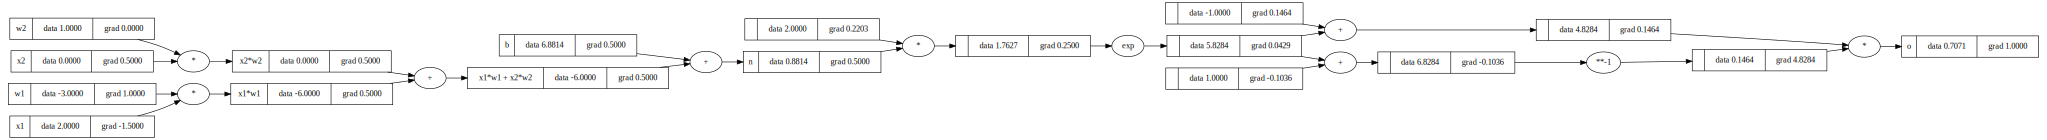

In [72]:
draw_dot(o)  

In [ ]:
import torch

In [76]:

"""
우리는 scalar value만 가지게 했지만, torch에서는 모든게 tensor이다. scalar들의 벡터로 이뤄져있다.
double로 바꾸는 이유는 default datatype이 torch.float32기 때문에. torch.float64로 변경해줄수있다. .double()을 붙임으로써.
그리고, default로 leaf node는 gradient가 필요없다고 여긴다. 
"""

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad =True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad= True
n = x1*w1 + x2*w2 + b

o = torch.tanh(n)

print(o.data.item())
o.backward()
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())


0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [77]:
torch.Tensor([[1,2,3], [4,5,6]]).shape

torch.Size([2, 3])

In [79]:
o # or o.item() or o.data.item()

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [82]:
x2.grad #.item() 하면 value만 얻을수있어.
print(x2.grad, x2.grad.item())

tensor([0.5000], dtype=torch.float64) 0.5000001283844369


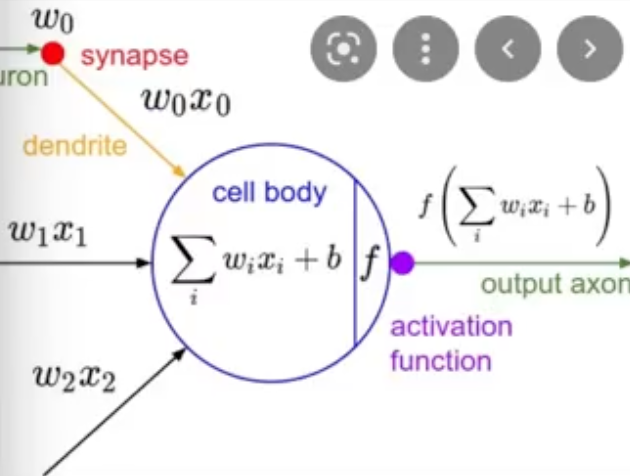

뉴런이 각각의 input(x1,x2 .. )에 대해서 weight를 가지고 있어야 해



In [133]:
# neural network - 2layer neural network 지을거야.

class Neuron:
    def __init__(self, nin): # [number of inputs] to this neuron 을 받을거야
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x): #x도 list야
        # w * x + b
        # 모든 w와 x를 각각 곱해줘야함
        act = sum((wi*xi for wi, xi in zip(self.w, x)),self.b) # [(w1,x1), (w2,x2) ] 형태로 만들어줌
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b] # extended list를 얻는다.
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons] #fully connected
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        """
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
        """
    
class MLP: #여러 레이어가 중첩된 뉴럴네트워크
    def __init__(self, nin, nouts): # list of nouts. 즉 각 layer의 output 개수를 리스트로 갖고있다. 
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    



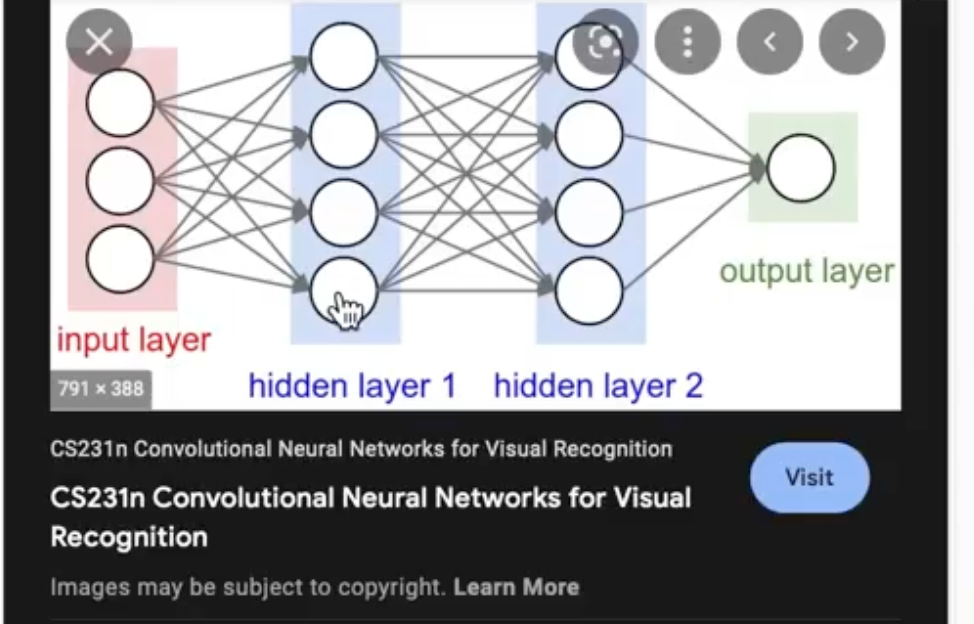
그리고, nlp 레이어는 여러개의 뉴런으로 이뤄져있다.


In [134]:
x = [2.0, 3.0]
#n = Neuron(2) #2개의숫자를 받는 뉴런을 만들래
n = Layer(2,3)
n(x)
x=[2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
o=n(x)


In [135]:
"""
[Value(data=0.590923324110873), -> 1.0
 Value(data=0.6840217160601341), -> -1.0
 Value(data=0.5666378032728074), -> -1.0
 Value(data=0.6279314018755978)] -> 1.0 
 으로 어떻게 만들지??
loss 함수를 만들자. mean squared error loss 
 
 """
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0,-1.0,-1.0,1.0] # desired targets
# xs[0] -> ys[0]
# xs[1] -> ys[1]
ypred = [n(x) for x in xs]
ypred


[Value(data=0.5031903577886492),
 Value(data=0.5180892965359174),
 Value(data=0.5007018509476325),
 Value(data=0.44480294738242915)]

In [136]:
"""
**2를 하는건 square을 씌워서 언제나 크기를 나타내도록. 
[Value(data=0.16734372675649786),
 Value(data=2.835929140162119),
 Value(data=2.4543540066434475),
 Value(data=0.1384350417102579)]
"""
loss = [(yout -ygt)**2 for ygt, yout in zip(ys, ypred)] #y ground truth, y output (prediction)
print(loss,sum(loss))
loss =sum(loss)


[Value(data=0.2468198205941704), Value(data=2.3045951122569166), Value(data=2.2521060454376505), Value(data=0.3082437672352378)] Value(data=5.111764745523976)


In [137]:
loss.backward()

In [138]:
n.layers[0].neurons[0].w[0].grad #이게 생겼다! 이 weight
# 여기의 grad가 양수라면 기울기가 양수라서, w값을 늘리면 loss(최종 output)값이 커지고, w값을 줄이면 (최종 output)값이 작아져. 
# 이제 우리는 이값을 이용해서 w를 업데이트 해주고 싶다. -> 이게 gradient descent의 idea

-0.2021559219530885

In [139]:
n.layers[0].neurons[0].w[0].data
# draw_dot(loss) 

0.9788932176182277

In [140]:
"""
gradient descent -> p.data를 p.grad 만큼 더해줘.
"""
for p in n.parameters(): # all parameters
    p.data += -0.01 * p.grad # parameter에 gradient descent 방식으로 파라미터의 수치를 조정한다 (w값을 조정)

    

In [141]:
n.layers[0].neurons[0].w[0].data # 원하던대로 우리가 바라던 값과 더 가까워졌다.

0.9809147768377585

In [142]:
"""
이제 loss가 더 줄어들어있을것이다. 
"""
ypred = [n(x) for x in xs]
loss = [(yout -ygt)**2 for ygt, yout in zip(ys, ypred)] #y ground truth, y output (prediction)
print(loss,sum(loss))
loss =sum(loss) 
# loss.backward()
# for p in n.parameters(): # all parameters
    # p.data += -0.01 * p.grad # parameter에 gradient descent 방식으로 파라미터의 수치를 조정한다 (w값을 조정)


[Value(data=0.32545126826692866), Value(data=2.038255622718427), Value(data=1.9870823328647722), Value(data=0.37817604407242833)] Value(data=4.728965267922557)


In [151]:
n = MLP(3,[4,4,1])
o=n(x)
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0,-1.0,-1.0,1.0] # desired targets
# xs[0] -> ys[0]
# xs[1] -> ys[1]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9851993935206496),
 Value(data=0.9895181743867152),
 Value(data=0.8221089441163498),
 Value(data=0.9922692767586669)]

In [152]:
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum([(yout -ygt)**2 for ygt, yout in zip(ys, ypred)]) #y ground truth, y output (prediction)

    #backward pass
    for p in n.parameters(): # all parameters
        p.grad=0.0
    loss.backward()
    
    #update
    for p in n.parameters(): # all parameters
        p.data += -0.05 * p.grad # parameter에 gradient descent 방식으로 파라미터의 수치를 조정한다 (w값을 조정)
    #p.grad는 += 이 계속되니까, p.grad를 0으로 안 만들면 안돼.-> torch에서는 매 epoch마다 zero_grad를 호출해줘야 한다.
    
    print(k, loss.data)

0 7.2785423924778385
1 6.5143909587126805
2 4.854087493976169
3 4.044471507019986
4 3.9074849500293642
5 3.7676278372749756
6 3.3330229478110205
7 0.4265685375045085
8 0.13069807990680246
9 0.10429377297590643
10 0.08757847904236853
11 0.07581949275526684
12 0.06701534054660375
13 0.06013814383539423
14 0.05459702981253589
15 0.05002509849376395
16 0.04618113406483637
17 0.042899360060837194
18 0.04006172052858045
19 0.03758164973128741


In [154]:
ypred

[Value(data=0.8992479489424641),
 Value(data=-0.8865797106052724),
 Value(data=-0.8991577712443546),
 Value(data=0.9336874311144757)]